In [1]:
# Create a browser object
import mechanize
import urllib2
import urllib
import requests

proxy = urllib2.ProxyHandler({'http': 'http://mepry.mignetwork.net:8080'})
opener = urllib2.build_opener(proxy)
urllib2.install_opener(opener)

br = mechanize.Browser(factory=mechanize.RobustFactory())
#br.set_all_readonly(False)    # allow everything to be written to
br.set_handle_robots(False)   # ignore robots
br.set_handle_refresh(False)  # can sometimes hang without this

# Open a webpage
url = "https://www.belpex.be/market-results/historical-data/"
br.open(url)
#response = br.open(url)
#print response.read()      # the text of the page
#response1 = br.response()  # get the response again
#print response1.read()     # can apply lxml.html.fromstring()

# List the forms that are in the page
#for form in br.forms():
#    print "Form name:", form.name
#    print form
    
# To go on the mechanize browser object must have a form selected
br.select_form("loginform")         # works when form has a name
#br.form = list(br.forms())[0]  # use when form is unnamed
br['log']="username"
#br["pwd"]="AKn0a6XtYgMU"
br['pwd']="********"
br.submit()

# List the forms that are in the page
#for form in br.forms():
#    print "Form name:", form.name
#    print form

br.form = list(br.forms())[2]
year = "2017"
br["year"]=[year]
br.submit()

#response = br.submit()
with open("spotmarket_data_"+year+".xls","wb") as fileobj:
    fileobj.write(br.response().read())
fileobj.close()


In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import datetime
import time
#import numpy as np
#import math

# read belpex data
# first download by using Mechanize_Example.py

years = ["2016","2017"]
df = pd.DataFrame()
data = pd.DataFrame()
for year in years:
    
    #excelfile = "Belpex"+year+".xls"
    excelfile = "spotmarket_data_"+year+".xls"
    rawpricedata = pd.read_excel(excelfile,sheetname=1)
    rawvoldata = pd.read_excel(excelfile,sheetname=0)

    dropcols = ['Date','BASE (00-24)','PEAK (09-20)','Off PEAK (00-08,21-24)']
    rawpricedata.drop(labels=dropcols,axis=1,inplace=True)
    rawvoldata.drop(labels=dropcols,axis=1,inplace=True)

    pricedata = pd.melt(rawpricedata,id_vars=['PRICES'])
    voldata = pd.melt(rawvoldata,id_vars=['VOLUMES'])

    data = pd.merge(pricedata,voldata,left_on=['PRICES','variable'],right_on=['VOLUMES','variable'],how='left')
    data.drop(labels=['VOLUMES'],axis=1,inplace=True)
    data.columns = ['Date','Hour','Price','Volume']

    data = data.dropna()

    def createTimeStamp(row):
        date = row['Date']
        hour = float(row['Hour'].split(' ')[1])-1
        date = date + pd.DateOffset(hours=hour)
        return date

    data['TimeStamp'] = data.apply(lambda row: createTimeStamp(row), axis=1)
    data.sort_values(by='TimeStamp',inplace=True)
    data = data.set_index('TimeStamp')
    
    #data.to_csv("BELPEX_DayAheadPrices_2016.csv", sep=";")
    
    df = pd.concat([df,data])
    
data = df[df.index >= '2016-10-01 00:00:00']

In [3]:
data.describe()

,Price,Volume
count,2833.000000,2833.000000
mean,61.797314,2678.886269
std,35.148946,694.605365
min,10.880000,1050.900000
25%,42.100000,2150.600000
50%,54.760000,2580.800000
75%,71.990000,3111.100000
max,696.020000,4992.500000


In [4]:
# read IP21 tag data
# download energy consumption data

start_time = time.time()

strConnect = 'DSN=KA_ODBC'
strAsOfDate = '01-OCT-16 00:00:01.0'
strUpToDate = '26-JAN-17 00:00:01.0'
strTagName = 'KAP3XI1850/1_P'

#sql = "SELECT TS,VALUE,SECONDS FROM HISTORY WHERE Name = '" + strTagName + "' AND TS > '" + strAsOfDate + "'"
sql = "SELECT TS_START, AVG, good FROM aggregates "\
    "WHERE name= '" + strTagName + "' "\
    "AND TS > '" + strAsOfDate + "' "\
    "AND period = 1:00 "\
    "AND request = 1;"

cnn = pyodbc.connect(strConnect)
data1 = pd.read_sql(sql, cnn)
cnn.close
data1['TS_START'] = pd.to_datetime(data1['TS_START'])
data1.set_index('TS_START',inplace=True)
data1 = data1.drop('good',axis=1)
data2 = data1.resample('H').mean()
data2.columns = ['H_Avg']
data3 = data1.resample('D').mean()
data4 = data3.resample('H').ffill()
data4.columns = ['D_Avg']
data2 = pd.concat([data2,data4],axis=1)
#totcons = np.trapz(data1['VALUE'],data1.index)
#avgcons = totcons/len(data1.index)
#t = np.repeat(avgcons,len(dt))

#data2['D_Avg']=4666.0
data2.describe()

C:\Users\MECLIJDA\AppData\Local\Enthought\Canopy32\User\lib\site-packages\numpy\lib\function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


,H_Avg,D_Avg
count,2818.000000,2809.000000
mean,3860.977469,3873.820103
std,2169.259850,1921.636947
min,0.000000,0.000000
25%,3476.610658,NaN
50%,4284.101528,NaN
75%,5131.199685,NaN
max,8971.913889,7767.120309


In [5]:
data = pd.concat([data,data2],axis=1)
data = data.fillna(method='pad')
data['NetHourlyGain'] = (data['D_Avg']-data['H_Avg'])*data['Price']/1000
#data['NetHourlyGain'] = (4666-data['H_Avg'])*data['Price']/1000
data['CumDailyGain'] = data.groupby(data.index.to_period('M'))['NetHourlyGain'].cumsum()
#data['CumDailyGain'] = data['NetHourlyGain'].cumsum()

In [6]:
data['2016-10-30 00:00:00.0':'2016-10-31 00:00:00.0']

,Date,Hour,Price,Volume,H_Avg,D_Avg,NetHourlyGain,CumDailyGain
2016-10-30 00:00:00,2016-10-30,Hour 01,45.00,2052.4,4536.206503,3014.431154,-68.479891,4220.015972
2016-10-30 01:00:00,2016-10-30,Hour 02,42.87,1974.3,4567.226790,3014.431154,-66.568349,4153.447623
2016-10-30 02:00:00,2016-10-30,Hour 03,38.62,1814.3,4340.591367,3014.431154,-51.216307,4102.231316
2016-10-30 03:00:00,2016-10-30,Hour 04,38.05,1829.2,4029.487913,3014.431154,-38.622910,4063.608406
2016-10-30 04:00:00,2016-10-30,Hour 05,31.40,2249.3,3901.889010,3014.431154,-27.866177,4035.742230
2016-10-30 05:00:00,2016-10-30,Hour 06,31.45,2452.6,3907.524883,3014.431154,-28.087798,4007.654432
2016-10-30 06:00:00,2016-10-30,Hour 07,32.03,2497.8,3754.943497,3014.431154,-23.718610,3983.935822
2016-10-30 07:00:00,2016-10-30,Hour 08,32.55,2320.8,3224.957601,3014.431154,-6.852636,3977.083186
2016-10-30 08:00:00,2016-10-30,Hour 09,33.35,2315.7,3216.297239,3014.431154,-6.732234,3970.350952
2016-10-30 09:00:00,2016-10-30,Hour 10,35.02,2174.8,3197.929418,3014.431154,-6.426109,3963.924843


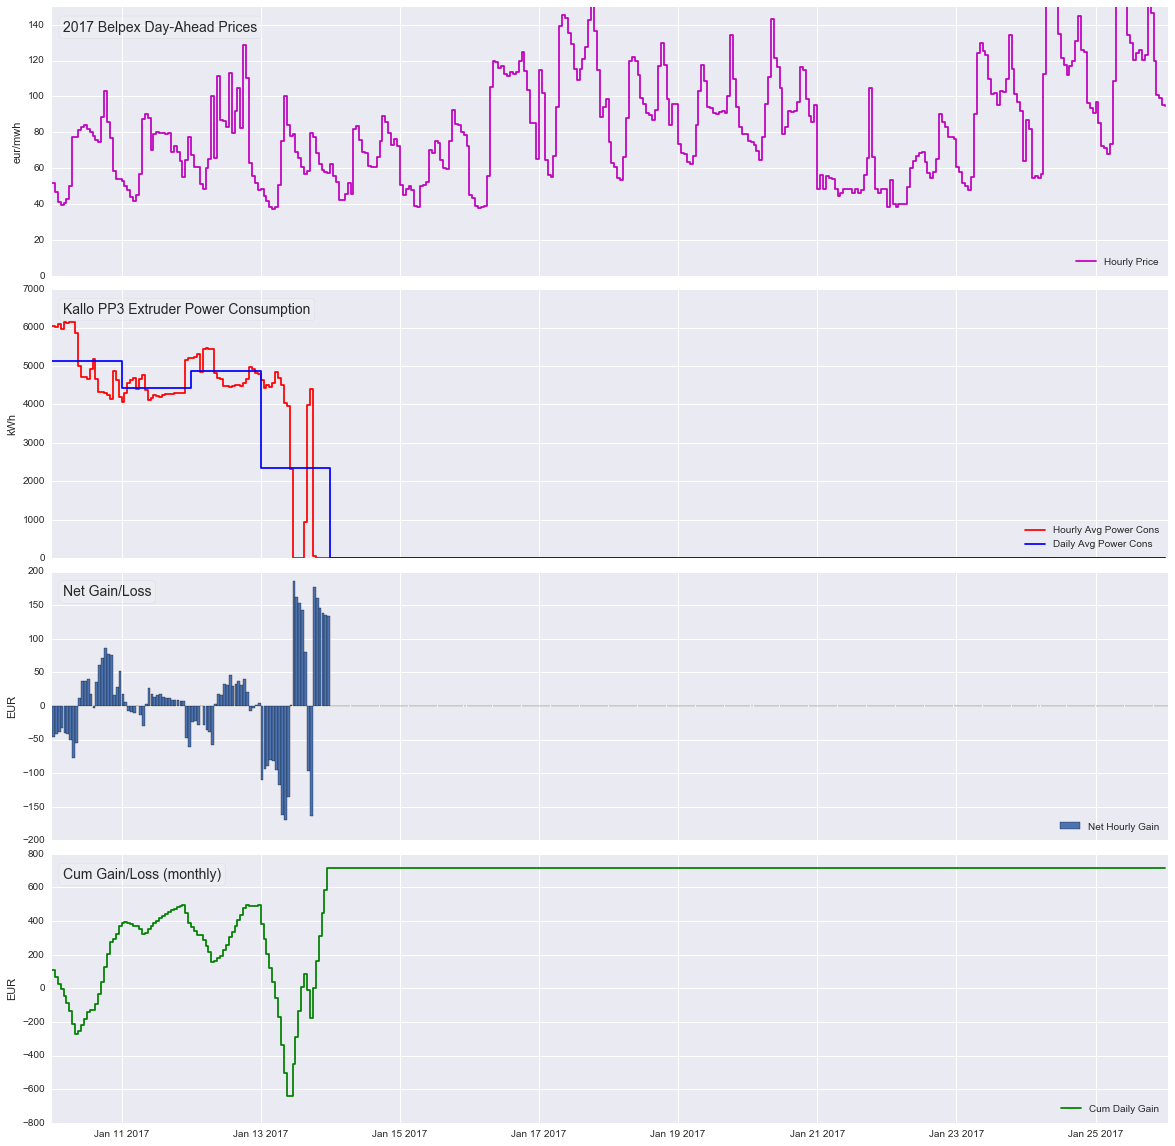

In [10]:
start = '2017-01-10 00:00:00.0'
stop = '2017-01-26 00:00:00.0'
plotdata = data[start:stop]
#plotdata = data

#import matplotlib.pyplot as plt
f = plt.figure(1, figsize=(20,20))
#plt.style.use('ggplot')
ax1 = plt.subplot(4,1,1)
ax1.set_ylim([0,150])
plt.plot(plotdata.index,plotdata['Price'],'m-',drawstyle='steps-post',label='Hourly Price')
plt.ylabel('eur/mwh')
plt.legend(loc='lower right')

ax2 = plt.subplot(4,1,2, sharex=ax1)
#plt.plot(data1[start:stop].index,data1[start:stop]['VALUE'],'c-',label='Actual Power Cons')
#plt.plot(data1.index,data1['VALUE'],'c-',label='Actual Power Cons')
plt.plot(plotdata.index,plotdata['H_Avg'],'r-',drawstyle='steps-post',label='Hourly Avg Power Cons')
plt.plot(plotdata.index,plotdata['D_Avg'],'b-',drawstyle='steps-post',label='Daily Avg Power Cons')
#plt.fill_between(plotdata.index,y1=plotdata['H_Avg'],y2=plotdata['D_Avg'],color='grey',alpha=0.5)
plt.ylabel('kWh')
plt.legend(loc='lower right')

#ax3 = plt.subplot(4,1,3, sharex=ax1, sharey=ax2)
#plt.plot(data1[start:stop].index,data1[start:stop]['VALUE'],'r-',label='Actual Power Cons')
#plt.ylabel('kWh')
##plt.title('Kallo PP3 Extruder Power Consumption')
#plt.legend(loc='lower right')

ax4 = plt.subplot(4,1,3, sharex=ax1)
plt.bar(plotdata.index,plotdata['NetHourlyGain'],0.04,label='Net Hourly Gain')
#plt.plot(plotdata.index,plotdata['CumDailyGain'],'g-',drawstyle = 'steps-post',label='Cum Daily Gain')
plt.ylabel('EUR')
plt.legend(loc='lower right')

ax5 = plt.subplot(4,1,4, sharex=ax1)
plt.plot(plotdata.index,plotdata['CumDailyGain'],'g-',drawstyle = 'steps-post',label='Cum Daily Gain')
plt.ylabel('EUR')
plt.legend(loc='lower right')

f.subplots_adjust(hspace=0.05)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

axes = f.get_axes()
props = dict(boxstyle='round', facecolor='white', alpha=0.1)
textstr=year + ' Belpex Day-Ahead Prices'
plt.text(0.01, 0.95, textstr, transform=axes[0].transAxes, fontsize=14, verticalalignment='top', bbox=props)
textstr='Kallo PP3 Extruder Power Consumption'
plt.text(0.01, 0.95, textstr, transform=axes[1].transAxes, fontsize=14,verticalalignment='top', bbox=props)
textstr='Net Gain/Loss'
plt.text(0.01, 0.95, textstr, transform=axes[2].transAxes, fontsize=14,verticalalignment='top', bbox=props)
textstr='Cum Gain/Loss (monthly)'
plt.text(0.01, 0.95, textstr, transform=axes[3].transAxes, fontsize=14,verticalalignment='top', bbox=props)

plt.show()


https://blog.dominodatalab.com/interactive-dashboards-in-jupyter/